# ScRRAMBLe on MNIST with Data Augmentation
- Using the same pipeline for MNIST, we want to make a quick analysis if data augementation can help in some ways.
- The goal is to potentially go from 97% accuracy to 98%.
- This notebook shold also consist of a dataloader that augments MNIST.

## Data Augementation strategies
- For MNIST, we can't simply apply rotations/flipping as some digits might get messed up e.g. "6" inverted is "9"
- For starters, let's focus on translations and $\leq 10 \degree$ rotations

In [3]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

from utils import clipping_ste, intercore_connectivity, load_mnist_with_validation
from models import ScRRAMBLeLayer


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

2025-06-19 18:25:28.079608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750382728.093068 2450556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750382728.097422 2450556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750382728.109055 2450556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750382728.109071 2450556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750382728.109073 2450556 computation_placer.cc:177] computation placer alr

In [4]:
## Some helper functions
def noisy_relu(x, **kwargs):
    """Noisy ReLU activation"""

    return nnx.relu(x)

In [5]:
# re-using the ScRRAMBLe MNIST model
class ScRRAMBLeMNIST(nnx.Module):
    """
    MNIST Classifier using ScRRAMBLE architecture
    """

    def __init__(
        self,
        input_vector_size: int,
        input_cores: int,
        output_cores: int,
        avg_slot_connectivity: int, 
        slots_per_core: int,
        slot_length: int,
        activation: Callable,
        rngs: nnx.Rngs,
        group_size: int,
        core_length: int = 256,
        threshold: float = 0.0,
        noise_sd: float = 0.05,


    ):

        self.input_vector_size = input_vector_size
        self.input_cores = input_cores
        self.output_cores = output_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.rngs = rngs
        self.group_size = group_size
        self.core_length = core_length
        self.threshold = threshold
        self.noise_sd = noise_sd
        self.activation = partial(activation, threshold=threshold, noise_sd=noise_sd, key=rngs.activation())

        # define the scrramble layer
        self.scrramble_layer = ScRRAMBLeLayer(
            input_vector_size=input_vector_size,
            input_cores=input_cores,
            output_cores=output_cores,
            avg_slot_connectivity=avg_slot_connectivity,
            slots_per_core=slots_per_core,
            slot_length=slot_length,
            activation=activation,
            rngs=rngs,
            core_length=core_length,
            threshold=threshold,
            noise_sd=noise_sd
        )

    @staticmethod
    def chunkwise_reshape(x):
        """
        Reshape the input in a block-wise manner similar to how a conv layer would process an image
        Args:
            x: jax.Array, input data (image)
        Returns:
            x: jax.Array, flattened data
        """
        # reshape into 32x32
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')

        # reshape again
        x = jnp.reshape(x, (x.shape[0], 8, 8, 4, 4, 1))

        # flatten along the last two dimensions
        x = jnp.reshape(x, (x.shape[0], 8, 8, -1))

        # flatten the first two dimensions
        x = jnp.reshape(x, (x.shape[0], -1))

        return x



    @partial(nnx.jit, static_argnames=['output_coding'])
    def __call__(self, x, output_coding: str = 'population'):
        """
        Forward pass for the ScRRAMBLe MNIST classifier
        Args:
            x: jax.Array, input data. Assumed to be flattened MNIST image. No batch.
            output_coding: str, specifies how the binary output should be interpreted. Choices are: ['population', 'svm', ...]. Only 'population' is implemented so far.
        Returns:
            out: jax.Array, output of classifier with population coding applied. (batch_size, group_size)
        """

        # reshape the image
        # print(x.shape)
        # x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')
        # x = x.reshape(x.shape[0], -1)

        x = self.chunkwise_reshape(x)

        # using vmap do the forward pass
        y = nnx.vmap(self.scrramble_layer, in_axes=0)(x)

        # check if population coding is used
        if output_coding == 'population':

            # truncation
            y_reshaped = y.reshape(y.shape[0], y.shape[1], -1)
            y_reshaped = y_reshaped[..., :250]

            y_reshaped = y_reshaped.reshape(y_reshaped.shape[0], self.group_size, -1)
            y_reshaped = jnp.mean(y_reshaped, axis=-1)
            
            return y_reshaped
            
        else:
            raise NotImplementedError("Non-population coding not implemented yet.")


    def get_params(self):
        """
        Get the number of parameters in the model
        Naive implementation
        """
        Wi = self.scrramble_layer.Wi.value.flatten()
        Wo = self.scrramble_layer.Wo.value.flatten()
        params = Wi.shape[0] + Wo.shape[0]

        return params

## Data Loading and Augmentation

In [ ]:
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 64, # 64 is a good batch size for MNIST
    'train_steps': 20000, # run for longer, 20000 is good!
    'binarize': True, 
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 500,
}


def load_and_augment_mnist(
    batch_size: int,
    train_steps: int,
    binarize: bool,
    greyscale: bool,
    data_dir: str,
    seed: int,
    shuffle_buffer: int,
    threshold: float, # this is the binarization threshold, not to be confused with the threshold in the model
    augmentation: bool = True,
    aug_translate: bool = True,
    num_translations: int = 4,
    max_shift: int = 3,
    # aug_rotate: float = 10 # degrees
):

    """
    Load and augment the MNIST dataset
    """

    tf.random.set_seed(seed)

    # do train-valid-test split
    train_ds, valid_ds, test_ds = tfds.load('mnist', split=['train[:50000]', 'train[50000:]', 'test'], data_dir=data_dir)

    ## adding helper function

    # normalize
    def _normalize(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0
        return {'image': img, 'label': sample['label']}

    # translate by a few pixels
    def _translate(image, dx, dy):
        """
        Translate image by dx, dy pixels
        """

        if dx != 0:
            image = tf.roll(image, shift=int(dx), axis=1)
        else:
            pass

        if dy != 0:
            image = tf.roll(image, shift=int(dy), axis=0)
        else:
            pass

        return image
    
    #  a function that puts together the augmented dataset
    def create_augmented_dataset(sample, num_translations=num_translations):

        image = sample['image']
        label = sample['label']

        images = [image]
        labels = [label]

        for _ in range(num_translations):
            # sample dx from a uniform
            dx = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
            dy = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
            translated_image = _translate(image, dx ,dy)
            images.append(translated_image)
            labels.append(label)

        # stack the images
        stacked_images = tf.stack(images)
        stacked_labels = tf.stack(labels)

        aug_dataset = tf.data.Dataset.from_tensor_slices({
            'image': stacked_images,
            'label': stacked_labels
        })

        return aug_dataset

    # check for flags and apply augmentation
    if augmentation:
        train_ds = train_ds.map(create_augmented_dataset).flat_map(lambda x: x)

    # normalize
    def _normalize(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0
        return {'image': img, 'label': sample['label']}

    train_ds = train_ds.map(_normalize)
    valid_ds = valid_ds.map(_normalize)
    test_ds = test_ds.map(_normalize)

    # apply binarization
    if binarize:
        binarize_mask = lambda s: {
            'image': tf.where(s['image'] > threshold, 1.0, 0.0),
            'label': s['label']
        }

        train_ds = train_ds.map(binarize_mask)
        valid_ds = valid_ds.map(binarize_mask)
        test_ds = test_ds.map(binarize_mask)
    else:
        pass

    # TODO: apply greyscale if more than 3 channels

    # Prepare datasets
    train_ds = train_ds.repeat().shuffle(shuffle_buffer)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
    valid_ds = valid_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, valid_ds, test_ds



Train dataset size: 20000 batches of size 64
Validation dataset size: 156 batches of size 64
Test dataset size: 156 batches of size 64


2025-06-19 18:41:48.135233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


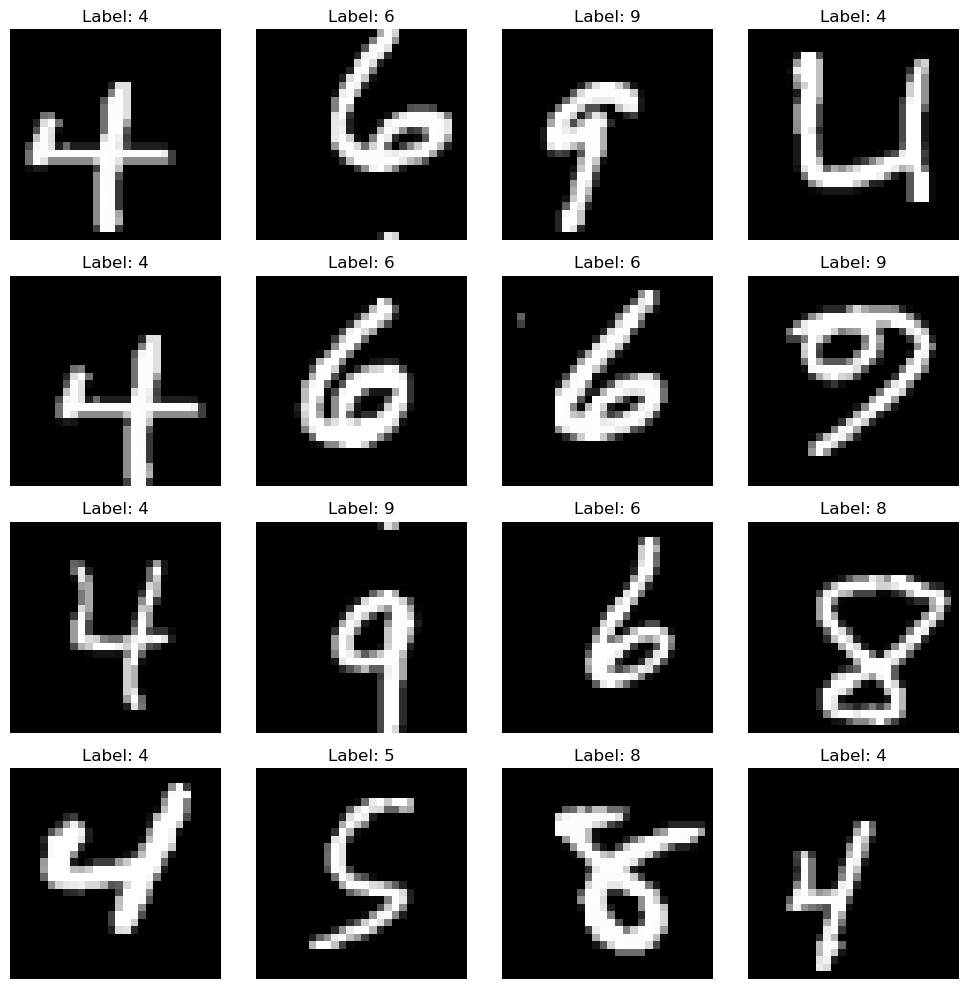

In [22]:
# testing the loading function
train_ds, valid_ds, test_ds = load_and_augment_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    binarize=dataset_dict['binarize'],
    greyscale=dataset_dict['greyscale'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    threshold=dataset_dict['threshold']
)

# print the size of all datasets
print(f"Train dataset size: {len(train_ds)} batches of size {dataset_dict['batch_size']}")
print(f"Validation dataset size: {len(valid_ds)} batches of size {dataset_dict['batch_size']}")
print(f"Test dataset size: {len(test_ds)} batches of size {dataset_dict['batch_size']}")

# plotting the first batch
batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch['image'][i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {batch['label'][i].numpy()}")
    plt.axis('off')
plt.tight_layout()

## Training Functions

In [8]:
# -------------------------------------------------------------------
# Training functions
# ------------------------------------------------------------------
def loss_fn(model: ScRRAMBLeMNIST, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: ScRRAMBLeMNIST, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: ScRRAMBLeMNIST, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

## Pipeline

In [27]:
total_cores = 32
ni = 20
ni, no = [ni, total_cores - ni]

print(f"No. of cores = {ni + no}")

rngs = nnx.Rngs(params=0, activation=1, permute=2)
model = ScRRAMBLeMNIST(
    input_vector_size=32*32,
    input_cores=ni,
    output_cores=no,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    activation=noisy_relu,
    rngs=rngs,
    group_size=10,
    core_length=256,
    threshold=0.0,
    noise_sd=0.05 # standard deviation of the noise distribution (typical value = 0.05)
)

print(f"Model parameters: {model.get_params()}")

# optimizers
hyperparameters = {
    'learning_rate': 7e-4, # 1e-3 seems to work well
    'momentum': 0.9, 
    'weight_decay': 1e-4
}

optimizer = nnx.Optimizer(
    model,
    optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
)

metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss')
)

No. of cores = 32
Model parameters: 2097152


## Training loop

In [33]:
metrics_history = {
'train_loss': [],
'train_accuracy': [],
'valid_loss': [],
'valid_accuracy': [],
'step': [],
}

def train_scrramble_mnist(model = model, 
                            optimizer = optimizer, 
                            metrics = metrics, 
                            train_ds = train_ds, 
                            valid_ds = valid_ds, 
                            dataset_dict = dataset_dict,
                            save_model_flag = True,
                            save_metrics_flag = True):

    eval_every = dataset_dict['eval_every']
    train_steps = dataset_dict['train_steps']

    for step, batch in enumerate(train_ds.as_numpy_iterator()):
        # Run the optimization for one step and make a stateful update to the following:
        # - The train state's model parameters
        # - The optimizer state
        # - The training loss and accuracy batch metrics

        train_step(model, optimizer, metrics, batch)

        if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
            # Log the training metrics.
            metrics_history['step'].append(int(step))  # Record the step.
            for metric, value in metrics.compute().items():  # Compute the metrics.
                metrics_history[f'train_{metric}'].append(float(value))  # Record the metrics.
            metrics.reset()  # Reset the metrics for the test set.

            # Compute the metrics on the test set after each training epoch.
            for valid_batch in valid_ds.as_numpy_iterator():
                eval_step(model, metrics, valid_batch)

            # Log the valid metrics.
            for metric, value in metrics.compute().items():
                metrics_history[f'valid_{metric}'].append(float(value))
            metrics.reset()  # Reset the metrics for the next training epoch.

            print(f"Step {step}: Valid loss: {metrics_history['valid_loss'][-1]}, Accuracy: {metrics_history['valid_accuracy'][-1]}")

    best_accuracy = max(metrics_history['valid_accuracy'])
    print(f"Best accuracy: {best_accuracy}")

    if save_model_flag:
        today = date.today().isoformat()
        filename = f"sscamble_mnist_model_ci_{model.input_cores}_co_{model.output_cores}_acc_{best_accuracy*100:.0f}_{today}.pkl"
        graphdef, state = nnx.split(model)
        save_model(state, filename)

    if save_metrics_flag:
        today = date.today().isoformat()
        filename = f"sscamble_mnist_metrics_ci_{model.input_cores}_co_{model.output_cores}_acc_{best_accuracy*100:.0f}_{today}.pkl"
        save_metrics(metrics_history, filename)

    return model

In [34]:
model = train_scrramble_mnist(
        model=model,
        optimizer=optimizer,
        metrics=metrics,
        train_ds=train_ds,
        valid_ds=valid_ds,
        dataset_dict=dataset_dict,
        save_model_flag=False,
        save_metrics_flag=False
    )

Step 500: Valid loss: 0.08131381124258041, Accuracy: 0.9773637652397156
Step 1000: Valid loss: 0.07266853749752045, Accuracy: 0.9794671535491943
Step 1500: Valid loss: 0.07153709977865219, Accuracy: 0.9815705418586731
Step 2000: Valid loss: 0.06602653861045837, Accuracy: 0.9817708730697632
Step 2500: Valid loss: 0.06890809535980225, Accuracy: 0.9812700152397156
Step 3000: Valid loss: 0.065887451171875, Accuracy: 0.9823718070983887
Step 3500: Valid loss: 0.0768110454082489, Accuracy: 0.9785656929016113
Step 4000: Valid loss: 0.08049844205379486, Accuracy: 0.9769631624221802
Step 4500: Valid loss: 0.0648125559091568, Accuracy: 0.9816706776618958
Step 5000: Valid loss: 0.07468175143003464, Accuracy: 0.9805689454078674
Step 5500: Valid loss: 0.0753125324845314, Accuracy: 0.9786658883094788
Step 6000: Valid loss: 0.06681264936923981, Accuracy: 0.9809695482254028
Step 6500: Valid loss: 0.06858095526695251, Accuracy: 0.9809695482254028
Step 7000: Valid loss: 0.07306121289730072, Accuracy: 0.9

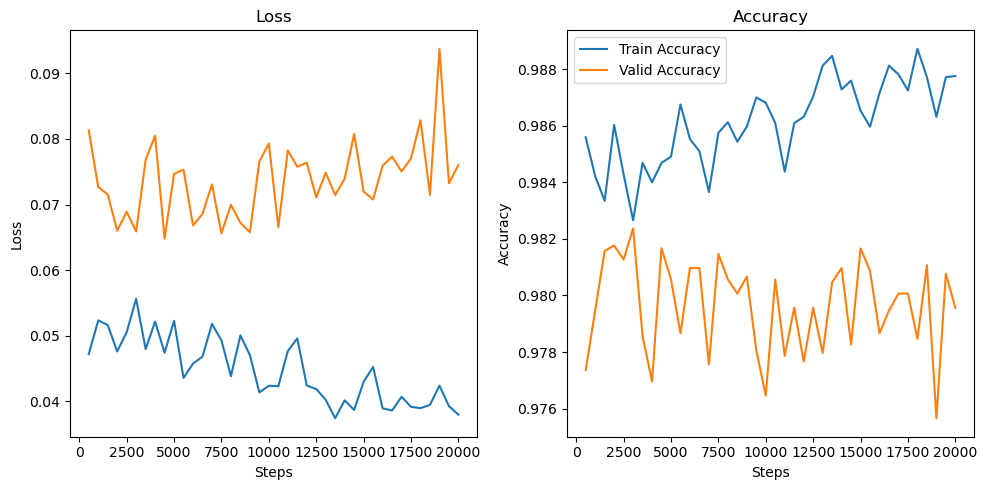

In [36]:
# plotting the training and validation loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(metrics_history['step'], metrics_history['train_loss'], label='Train Loss')
axs[0].plot(metrics_history['step'], metrics_history['valid_loss'], label='Valid Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Loss')

axs[1].plot(metrics_history['step'], metrics_history['train_accuracy'], label='Train Accuracy')
axs[1].plot(metrics_history['step'], metrics_history['valid_accuracy'], label='Valid Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()